# Retail Sales Analysis: What’s Driving Growth, Where Risk Is Building, and Why It Matters

This notebook contains the analytical workflow supporting the findings
summarized in the project README.

The analysis explores sales performance drivers, commercial risks,
and short-term recommendations using transactional retail data.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.ticker import PercentFormatter
from IPython.display import display, Markdown

sales_df = pd.read_csv("/kaggle/input/retail-sales-dataset/sales_clean.csv")
sales_df['month_period'] = pd.to_datetime(sales_df['month_period'])
sales_df.head()

,transaction_id,year,month_period,weekday,location,group,sub_group,quantity,sale_amount
0,T8492,2022,2022-10-01,Saturday,Store_1,Clothes,Blouses,1,10.00
1,T5479,2022,2022-10-01,Tuesday,Store_1,Clothes,Trouser suits,1,29.33
2,T4552,2022,2022-10-01,Saturday,Store_1,Clothes,Trouser suits,1,32.00
3,T7905,2022,2022-10-01,Wednesday,Store_1,Clothes,Short suits,1,24.67
4,T1830,2022,2022-10-01,Saturday,Store_2,Clothes,Blouses,1,12.67


## 1. Overall sales health: growth, volatility, and sustainability


In [19]:
# --- Metrics ---
monthly_df = (sales_df.groupby('month_period', as_index=False)
    .agg(total_sales=('sale_amount', 'sum')))

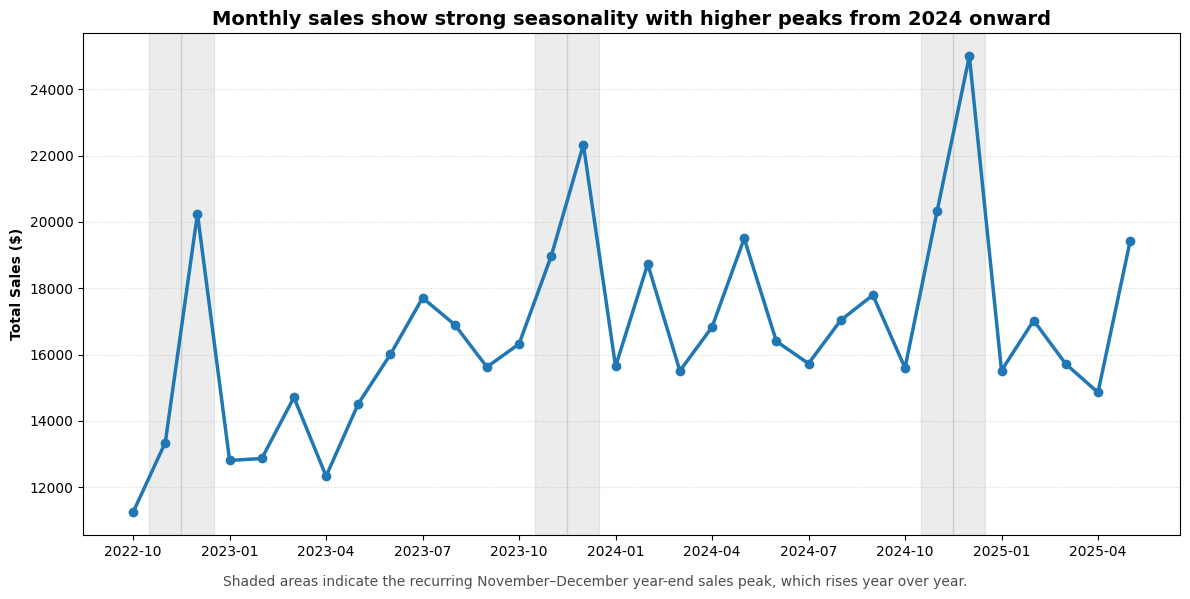

In [20]:
# ---Plot 1 : Monthly sales over the years---
fig1, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(monthly_df))
x_labels = monthly_df['month_period'].dt.strftime('%Y-%m')

# --- Sales line ---
ax1.plot(
    x,
    monthly_df['total_sales'],
    marker='o',
    linewidth=2.5
)
ax1.set_ylabel('Total Sales ($)', fontweight='bold')

# --- X-axis: show every 3rd month ---
tick_step = 3
ax1.set_xticks(list(x)[::tick_step])
ax1.set_xticklabels(x_labels[::tick_step])
ax1.tick_params(axis='x', rotation=0)

# --- Seasonal shading: Nov / Dec ---
for i, dt in enumerate(monthly_df['month_period']):
    if dt.month in (11, 12):
        ax1.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.15, zorder=0)

# --- Title & Grid ---
ax1.set_title(
    'Monthly sales show strong seasonality with higher peaks from 2024 onward',
    fontsize=14,
    fontweight='bold'
)
ax1.grid(axis='y', linestyle=':', alpha=0.5)

# --- Footnote ---
fig1.text(
    0.5, 0.01,
    'Shaded areas indicate the recurring November–December year-end sales peak, which rises year over year.',
    ha='center',
    va='bottom',
    fontsize=10,
    color='#4d4d4d'
)

# --- Layout ---
plt.tight_layout()
plt.subplots_adjust(bottom=0.10)
plt.show()


In [21]:
#---Table 1: YoY growth - 2023 and 2024

#---Data prep---
years = [2023, 2024]
yearly = (
    sales_df[sales_df['year'].isin(years)]
    .groupby('year')
    .agg(
        total_sales=('sale_amount', 'sum'),
        total_volume=('quantity', 'sum'),
        transactions=('transaction_id', 'nunique'),
        months_present=('month_period', 'nunique')
    )
)

yearly['avg_monthly_sales'] = yearly['total_sales'] / yearly['months_present']
yearly['avg_monthly_volume'] = yearly['total_volume'] / yearly['months_present']
yearly['avg_monthly_transactions'] = yearly['transactions'] / yearly['months_present']
yearly['avg_realized_price'] = yearly['total_sales'] / yearly['total_volume']
yearly['sales_per_transaction'] = yearly['total_sales'] / yearly['transactions']

metrics = [
    'total_sales', 'avg_monthly_sales',
    'total_volume', 'avg_monthly_volume',
    'transactions', 'avg_monthly_transactions',
    'avg_realized_price', 'sales_per_transaction'
]
#transpose the table
yoy_numeric = yearly[metrics].T
yoy_numeric.columns = yoy_numeric.columns.astype(str)  # "2023", "2024"

# YoY % (2024 vs 2023)
yoy_numeric['YoY_% (2024 vs 2023)'] = (yoy_numeric['2024'] / yoy_numeric['2023']) - 1

#---Table display---
yoy_display = yoy_numeric.copy().astype(object)

money = {'total_sales', 'avg_monthly_sales', 'sales_per_transaction'}
counts = {'total_volume', 'avg_monthly_volume', 'transactions', 'avg_monthly_transactions'}
price  = {'avg_realized_price'}

def format_value(idx, col, val):
    if pd.isna(val):
        return ""
    if col == 'YoY_% (2024 vs 2023)':
        return f"{val:+.1%}"
    if idx in money:
        return f"{val:,.2f}"
    if idx in counts:
        return f"{val:,.0f}"
    if idx in price:
        return f"{val:,.3f}"
    return f"{val}"

for idx in yoy_display.index:
    for col in yoy_display.columns:
        yoy_display.loc[idx, col] = format_value(idx, col, yoy_numeric.loc[idx, col])

yoy_display_styled = yoy_display.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
)

# --- Bold key rows only ---
rows_to_bold = ['total_volume', 'avg_realized_price', 'sales_per_transaction']

def bold_selected_rows(row):
    return ['font-weight: bold' if row.name in rows_to_bold else '' for _ in row]

yoy_display_styled = yoy_display_styled.apply(bold_selected_rows, axis=1)


yoy_display_styled


year,2023,2024,YoY_% (2024 vs 2023)
total_sales,"191,120.75","214,123.38",+12.0%
avg_monthly_sales,"15,926.73","17,843.62",+12.0%
total_volume,"7,090","6,595",-7.0%
avg_monthly_volume,591,550,-7.0%
transactions,"3,992","3,696",-7.4%
avg_monthly_transactions,333,308,-7.4%
avg_realized_price,26.956,32.468,+20.4%
sales_per_transaction,47.88,57.93,+21.0%


Monthly sales are highly seasonal, with a recurring November–December peak each year. While month-to-month volatility is high, peak sales levels rise over time, indicating higher monetization rather than smoother baseline demand. This establishes a growth pattern that depends on seasonal strength rather than consistent volume expansion.

Total sales grew +12% YoY, but growth is not demand-led.
Total volume declined −7%, with fewer units sold and fewer transactions.The avarage realized price +20.5% and sales per transaction +21%.

The business is generating more revenue per sale, not selling more units. Sustaining growth now requires either:

* **Stabilize or rebuild volume** by selling more items per visit, bringing customers back more often, or shifting sales toward higher-volume products, or
* **Continue price-led growth**, accepting weaker customer demand and heavier reliance on peak seasons.

### Growth mechanism: volume vs price


In [22]:

#---Metrics---
monthly_df = (
    sales_df
    .groupby('month_period', as_index=False)
    .agg(
        total_sales=('sale_amount', 'sum'),
        total_volume=('quantity', 'sum')
    )
)

monthly_df['rev_growth'] = monthly_df['total_sales'].pct_change()
monthly_df['vol_growth'] = monthly_df['total_volume'].pct_change()

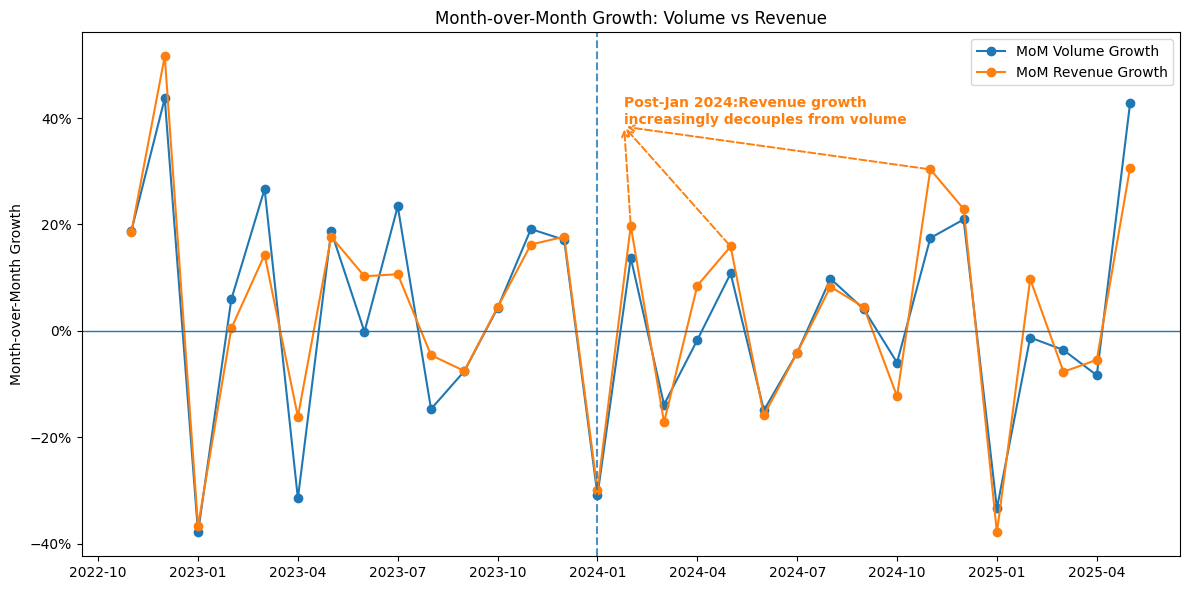

In [23]:
#---Plot 2: MoM Growth - Volume vs Revenue---
fig2, ax2 = plt.subplots(figsize=(12, 6))

x = range(len(monthly_df))
x_labels = monthly_df['month_period'].dt.strftime('%Y-%m')

#---MoM Volume Growth---
ax2.plot(
    x,
    monthly_df['vol_growth'],
    label='MoM Volume Growth',
    marker='o'
)

#---MoM Revenue Growth---
ax2.plot(
    x,
    monthly_df['rev_growth'],
    label='MoM Revenue Growth',
    marker='o'
)

#---Vertical reference line at Jan 2024---
jan_2024 = pd.Timestamp('2024-01-01')
jan_idx = monthly_df.index[monthly_df['month_period'] == jan_2024]

if len(jan_idx) > 0:
    jan_idx = int(jan_idx[0])
    ax2.axvline(jan_idx, linestyle='--', linewidth=1.5, alpha=0.8)

# --- Annotation---
rev_color = '#ff7f0e'
# Target months on the revenue line
target_months = [
    pd.Timestamp('2024-02-01'),
    pd.Timestamp('2024-05-01'),
    pd.Timestamp('2024-11-01')
]

# Robust index lookup
idxs = []
for t in target_months:
    exact = monthly_df.index[monthly_df['month_period'] == t]
    idxs.append(int(exact[0]) if len(exact) else int((monthly_df['month_period'] - t).abs().idxmin()))

x_points = idxs
y_points = [monthly_df['rev_growth'].iloc[i] for i in x_points]

# Place the callout near Feb 2024
feb_target = pd.Timestamp('2024-02-01')
feb_exact = monthly_df.index[monthly_df['month_period'] == feb_target]
feb_idx = int(feb_exact[0]) if len(feb_exact) else int((monthly_df['month_period'] - feb_target).abs().idxmin())

# Convergence point
x_conv = max(jan_idx + 0.6, feb_idx - 0.2)
ymin, ymax = ax2.get_ylim()
y_conv = ymin + 0.82 * (ymax - ymin)

# Three-line text placed at the convergence point
ax2.text(
    x_conv, y_conv,
    "Post-Jan 2024:Revenue growth\nincreasingly decouples from volume",
    color=rev_color,
    fontsize=10,
    ha='left',
    va='bottom',
    fontweight= 'bold'
)

# Three dashed arrows converging upward into the same point
for xp, yp in zip(x_points, y_points):
    ax2.annotate(
        '',
        xy=(x_conv, y_conv),
        xytext=(xp, yp),
        arrowprops=dict(
            arrowstyle='->',
            linestyle='--',
            color=rev_color,
            linewidth=1.4
        )
    )

#---Formatting---
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.axhline(0, linewidth=1)

tick_step = 3
ticks = list(range(0, len(monthly_df), tick_step))
ax2.set_xticks(ticks)
ax2.set_xticklabels(x_labels.iloc[ticks], rotation=0)

ax2.set_ylabel('Month-over-Month Growth')
ax2.legend(loc='upper right')

plt.title('Month-over-Month Growth: Volume vs Revenue')
plt.tight_layout()
plt.show()


Before 2024, revenue growth moved in line with volume, indicating demand-led performance. From 2024 onward, revenue continues to grow even as volume declines, confirming a shift to price-led growth. This growth model is fragile: if customers resist further price increases, revenue will fall quickly because volume is no longer supporting growth..

## 2. Price trends and promotional impact

In [24]:
#---Metrics---
sales_df['unit_price'] = sales_df['sale_amount'] / sales_df['quantity']
sales_df['is_discounted'] = sales_df['unit_price'] < 10
sales_df['discounted_quantity'] = sales_df['quantity'].where(sales_df['is_discounted'], 0)
monthly_df['avg_price'] = monthly_df['total_sales']/monthly_df['total_volume']

promo_df = (
    sales_df
    .groupby('month_period')
    .agg(
        total_units=('quantity', 'sum'),
        discounted_units=('discounted_quantity', 'sum')
    ).reset_index()
)

# Compute a 3-month rolling average
promo_df['discounted_share'] = promo_df['discounted_units'] / promo_df['total_units']
promo_df['rolling_avg'] = promo_df['discounted_share'].rolling(3, min_periods=1).mean()

# Flag months where discounted_share is above rolling average by 10%
promo_df['is_promo'] = promo_df['discounted_share'] > promo_df['rolling_avg'] * 1.1

# --- promo months list ---
promo_months = set(promo_df.loc[promo_df['is_promo'], 'month_period'])

# Mask promo months in monthly_df
is_promo_month = monthly_df['month_period'].isin(promo_months)

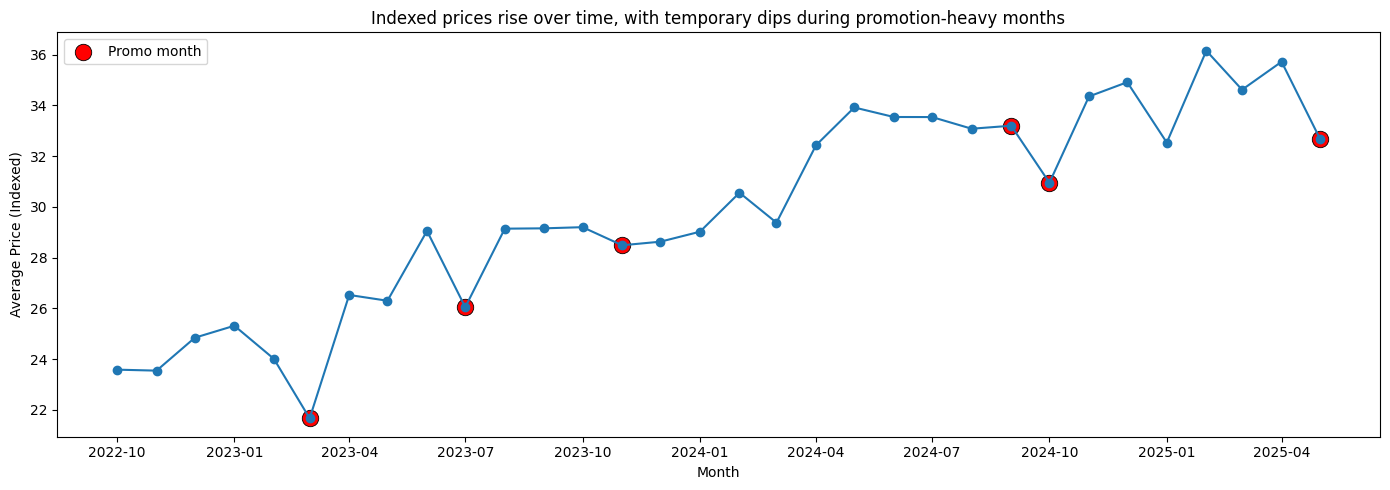

In [25]:
# --- Single chart ---
fig3, ax3 = plt.subplots(figsize=(14, 5))

# Data for promo overlays
x_vals = monthly_df['month_period']
x_promo = x_vals[is_promo_month]
y_price_lvl_promo = monthly_df.loc[is_promo_month, 'avg_price']


ax3.plot(x_vals, monthly_df['avg_price'], marker='o')
ax3.scatter(
    x_promo, y_price_lvl_promo,
    s=140, marker='o', color='red',
    edgecolors='black', linewidths=0.6,
    label='Promo month'
)

ax3.set_title('Indexed prices rise over time, with temporary dips during promotion-heavy months')
ax3.set_ylabel('Average Price (Indexed)')
ax3.set_xlabel('Month')
ax3.legend()

# X-axis: show every 3rd month
ticks = x_vals[::3]
ax3.set_xticks(ticks)
ax3.set_xticklabels(ticks.dt.strftime('%Y-%m'))

plt.tight_layout()
plt.show()


Average realized prices trend upward over the period, with temporary declines concentrated in promotion-heavy months. Importantly, these promotions do not reset the underlying price level.

From early 2024 onward, prices remain consistently higher, reinforcing the earlier finding that revenue growth is no longer driven by selling more units. Instead, growth is increasingly supported by higher prices and what customers buy, which we examine next.

## 3. Category & Product Mix: Where does revenue come from, and where is the risk?

In [26]:
#---Table 2: What % each sub_groub contributes to the total
sub_group_df = (
    sales_df
    .groupby('sub_group', dropna=False)
    .agg(
        sales=('sale_amount', 'sum'),
        volume=('quantity', 'sum'),
    )
    .reset_index()
)

# Shares + avg realized price
total_sales = sub_group_df['sales'].sum()
total_volume = sub_group_df['volume'].sum()

sub_group_df['sales_share'] = sub_group_df['sales'] / total_sales
sub_group_df['volume_share'] = sub_group_df['volume'] / total_volume
sub_group_df['share_gap'] = sub_group_df['sales_share'] - sub_group_df['volume_share']
sub_group_df['avg_realized_price'] = sub_group_df['sales'] / sub_group_df['volume']

# Sort + cumulative share (Pareto)
sub_group_df = sub_group_df.sort_values('sales', ascending=False).reset_index(drop=True)
sub_group_df['cum_sales_share'] = sub_group_df['sales_share'].cumsum()

# Keep rows up to 80% cutoff, roll the rest into "Other sub-groups"
cutoff = 0.80

keep_mask = sub_group_df['cum_sales_share'] <= cutoff

# Ensure no empty table if the top sub_group alone exceeds 80%
if keep_mask.sum() == 0:
    keep_mask.iloc[0] = True

kept = sub_group_df.loc[keep_mask].copy()
rest = sub_group_df.loc[~keep_mask].copy()


if not rest.empty:
    other = pd.DataFrame({
        'sub_group': ['Other sub-groups'],
        'sales': [rest['sales'].sum()],
        'volume': [rest['volume'].sum()],
          })
    other['sales_share'] = other['sales'] / total_sales
    other['volume_share'] = other['volume'] / total_volume
    other['share_gap'] = other['sales_share'] - other['volume_share']
    other['avg_realized_price'] = other['sales'] / other['volume']
    other['cum_sales_share'] = 1.0

    pareto_tbl = pd.concat([kept, other], ignore_index=True)
else:
    pareto_tbl = kept.copy()

# Clean display order + formatting-friendly columns
pareto_tbl = pareto_tbl[[
    'sub_group',
    'sales', 'sales_share',
    'volume', 'volume_share',
    'share_gap',
    'avg_realized_price',
    'cum_sales_share'
]]

pareto_display = pareto_tbl.copy().astype(object)

pareto_display['sales'] = pareto_tbl['sales'].map(lambda x: f"{x:,.2f}")
pareto_display['sales_share'] = pareto_tbl['sales_share'].map(lambda x: f"{x:.1%}")
pareto_display['volume'] = pareto_tbl['volume'].map(lambda x: f"{x:,.0f}")
pareto_display['volume_share'] = pareto_tbl['volume_share'].map(lambda x: f"{x:.1%}")
pareto_display['share_gap'] = pareto_tbl['share_gap'].map(lambda x: f"{x:+.1%}")
pareto_display['avg_realized_price'] = pareto_tbl['avg_realized_price'].map(lambda x: f"{x:,.3f}")
pareto_display['cum_sales_share'] = pareto_tbl['cum_sales_share'].map(lambda x: f"{x:.1%}")

# Bold selected sub_groups
bold_groups = {'Dresses', 'Blouses', 'Bag'}

def bold_selected_rows(row):
    return ['font-weight: bold' if row['sub_group'] in bold_groups else '' for _ in row]

pareto_display.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
).apply(bold_selected_rows, axis=1)


,sub_group,sales,sales_share,volume,volume_share,share_gap,avg_realized_price,cum_sales_share
0,Bag,"154,292.91",29.0%,"2,324",12.9%,+16.0%,66.391,29.0%
1,Dresses,"92,582.14",17.4%,"4,155",23.1%,-5.8%,22.282,46.3%
2,Heels,"52,185.77",9.8%,"1,616",9.0%,+0.8%,32.293,56.1%
3,Trouser suits,"38,576.81",7.2%,"1,020",5.7%,+1.6%,37.820,63.4%
4,Blouses,"31,254.49",5.9%,"2,438",13.6%,-7.7%,12.820,69.3%
5,Flats,"31,003.88",5.8%,"1,340",7.5%,-1.6%,23.137,75.1%
6,Jackets,"25,376.45",4.8%,726,4.0%,+0.7%,34.954,79.8%
7,Other sub-groups,"107,366.78",20.2%,"4,337",24.2%,-4.0%,24.756,100.0%


Sales are highly concentrated in Bags, which generate **29% of revenue from only 13% of units sold**. Nearly one-third of revenue depends on a category that does not move high volumes, creating clear concentration risk. Any disruption in this category would have an immediate impact on the P&L.

At the other extreme, Blouses drive a large share of unit sales but contribute little to revenue, suggesting that high volume does not translate into meaningful value.

This polarized mix raises a key question: do these categories react differently to price changes, and where is pricing power actually coming from?


## 4. Category pricing response: Which categories can absorb price increases?

In [27]:
#---Data Prep---
focus_categories = ['Bag', 'Dresses', 'Blouses']

cat_monthly = (
    sales_df.loc[sales_df['sub_group'].isin(focus_categories)]
    .groupby(['sub_group', 'month_period'], as_index=False)
    .agg(
        sales=('sale_amount', 'sum'),
        volume=('quantity', 'sum')
    )
)

cat_monthly['avg_price'] = cat_monthly['sales'] / cat_monthly['volume']
cat_monthly = cat_monthly.sort_values(['sub_group', 'month_period']).reset_index(drop=True)

# Base values per category (first month in each category)
cat_monthly['price_base'] = cat_monthly.groupby('sub_group')['avg_price'].transform('first')
cat_monthly['volume_base'] = cat_monthly.groupby('sub_group')['volume'].transform('first')

# Indexed series
cat_monthly['price_index'] = (cat_monthly['avg_price'] / cat_monthly['price_base']) * 100
cat_monthly['volume_index'] = (cat_monthly['volume'] / cat_monthly['volume_base']) * 100

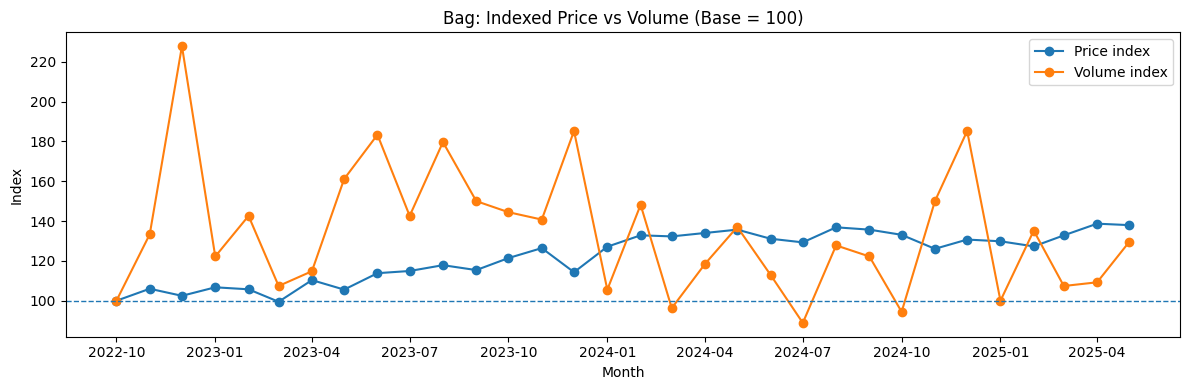

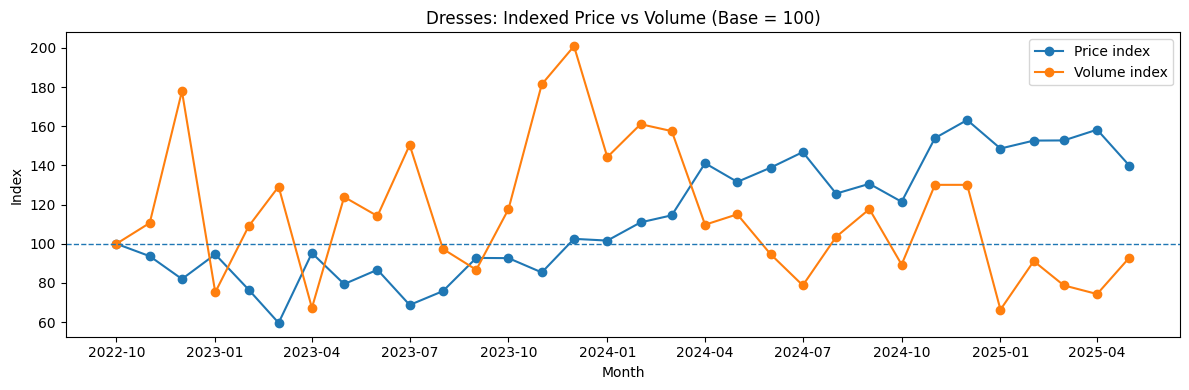

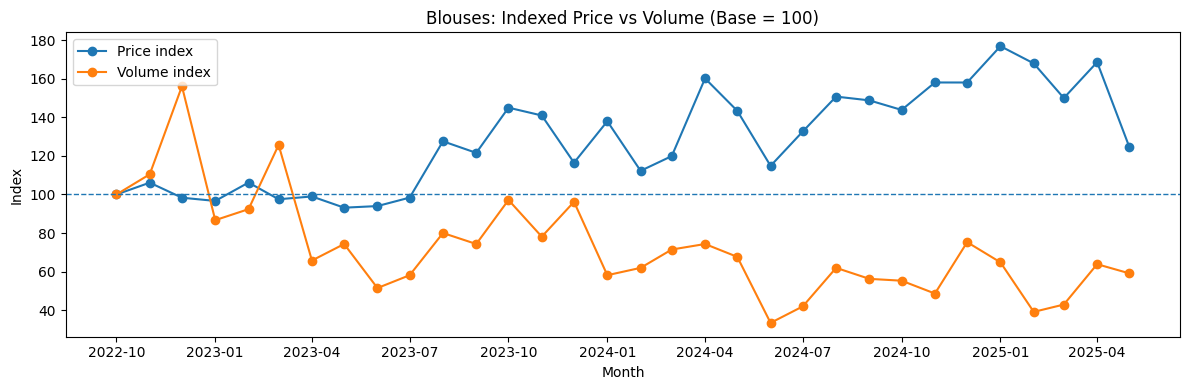

In [28]:

# --- Plot 4: Bags, Dresses & Blouses - volume vs price index---
for cat in focus_categories:
    dfc = cat_monthly.loc[cat_monthly['sub_group'] == cat].copy()
    x = dfc['month_period']

    fig4, ax4 = plt.subplots(figsize=(12, 4))

    ax4.plot(x, dfc['price_index'], label='Price index', marker='o')
    ax4.plot(x, dfc['volume_index'], label='Volume index', marker='o')

    ax4.axhline(100, linestyle='--', linewidth=1)
    ax4.set_title(f'{cat}: Indexed Price vs Volume (Base = 100)')
    ax4.set_ylabel('Index')
    ax4.set_xlabel('Month')
    ax4.legend()

    # X ticks: every 3rd month (no .dt error because x is datetime)
    ticks = x.iloc[::3]
    ax4.set_xticks(ticks)
    ax4.set_xticklabels(ticks.dt.strftime('%Y-%m'), rotation=0)

    plt.tight_layout()
    plt.show()

Indexed price–volume analysis shows clear differences by category:

* **Bags** show strong pricing power: price increases did not lead to a material decline in volume.

* **Dresses** show moderate price sensitivity: volumes have softened as prices rose, but demand has not collapsed.

* **Blouses** are highly price-sensitive: price increases were followed by sharp volume declines, indicating limited willingness to pay.

We next examine whether blouses rely on being bought together with other items rather than on standalone d

## 5. Basket behavior: why blouses respond differently to price


In [29]:
#---Table 3: blouse basket analysis
total_baskets = sales_df['transaction_id'].nunique()
blouse_baskets = sales_df.loc[sales_df['sub_group'] == 'Blouses', 'transaction_id'].nunique()
blouses_standalone = sales_df.groupby('transaction_id')['sub_group'].apply(lambda x: set(x) == {'Blouses'}).sum()

print(f"Total baskets: {total_baskets:,}")
print(f"Baskets with Blouses: {blouse_baskets:,}")
print(f"Baskets with Blouses standalone: {blouses_standalone:,}")

txn = sales_df.groupby('transaction_id')['sub_group'].apply(set)

# attachment tables
rows = []
all_categories = sorted({cat for cats in txn for cat in cats})

for cat in all_categories:
    tx_with_cat = txn.apply(lambda x: cat in x).sum()
    tx_with_cat_and_blouse = txn.apply(lambda x: (cat in x) and ('Blouses' in x)).sum()

    rows.append({
        'Category': cat,
        'Transactions with category': tx_with_cat,
        'Transactions with category + Blouses': tx_with_cat_and_blouse,
        'Attachment rate (Blouse | Category)': (tx_with_cat_and_blouse / tx_with_cat) if tx_with_cat > 0 else 0
    })

attach_tbl = pd.DataFrame(rows)
average_transaction_with_blouse = attach_tbl['Transactions with category + Blouses'].median()

# FILTER: keep only categories with above median baskets that include Blouses
attach_tbl = attach_tbl[attach_tbl['Transactions with category + Blouses'] > average_transaction_with_blouse].reset_index(drop=True)
attach_tbl = attach_tbl[attach_tbl['Category']!='Blouses'].reset_index(drop=True)
attach_tbl = attach_tbl.sort_values('Transactions with category + Blouses', ascending=False).reset_index(drop=True)

# table display
attach_display = attach_tbl.copy().astype(object)

attach_display['Transactions with category'] = attach_tbl['Transactions with category'].map(lambda x: f"{x:,}")
attach_display['Transactions with category + Blouses'] = attach_tbl['Transactions with category + Blouses'].map(lambda x: f"{x:,}")
attach_display['Attachment rate (Blouse | Category)'] = attach_tbl['Attachment rate (Blouse | Category)'].map(lambda x: f"{x:.1%}")

attach_display.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]}]
)

Total baskets: 10,008
Baskets with Blouses: 1,606
Baskets with Blouses standalone: 767


,Category,Transactions with category,Transactions with category + Blouses,Attachment rate (Blouse | Category)
0,Dresses,"2,759",400,14.5%
1,Trouser suits,800,196,24.5%
2,Trousers,435,186,42.8%
3,Jackets,597,127,21.3%
4,Skirt suit,327,65,19.9%
5,Tracksuits,237,55,23.2%
6,Skirts,131,50,38.2%
7,Heels,"1,333",49,3.7%
8,Bag,"1,907",40,2.1%
9,Flats,"1,071",40,3.7%


Blouses appear in **16% of all baskets** (1,605 of 10,007 transactions), indicating frequent inclusion in customer purchases.

However, blouse purchases do not reliably expand basket value. **Nearly half of blouse baskets (767 of 1,605, ~48%)** contain only Blouses, showing limited cross-category attachment.

This basket behavior helps explain the earlier price–volume result: when prices increase, volume drops sharply. Customers are willing to buy blouses at low prices, but demand falls quickly when prices rise.

Overall, Blouses function primarily as a traffic item rather than a value driver, explaining both their high price sensitivity and weak revenue contribution.

### **What this means for pricing decisions**
* **Bags:** Price increases are possible, but revenue is highly concentrated, making this category a key risk point.

* **Dresses:** Moderate price increases are possible, but rising price sensitivity means volume must be closely monitored.

* **Blouses:** Further price increases sharply reduce volume; value must come from being added to baskets rather than higher standalone prices.

## 6. Store performance and execution by format


In [30]:
location_monthly_df = (
    sales_df
    .groupby(['location', 'month_period'])
    .agg(
        sales=('sale_amount', 'sum'),
        volume=('quantity', 'sum')
    )
    .reset_index()
)

location_monthly_df['avg_price'] = (
    location_monthly_df['sales'] / location_monthly_df['volume']
)

# store group map
store_group_map = {
    'Store_1': 'Clothes-led',
    'Store_2': 'Clothes-led',
    'Store_3': 'Clothes-led',
    'Store_4': 'Bags-led',
    'Store_5': 'Bags-led',
    'Store_6': 'Bags-led'
}

location_monthly_df['store_group'] = location_monthly_df['location'].map(store_group_map)
group_contribution = (
    location_monthly_df
    .groupby('store_group')
    .agg(
        total_sales=('sales', 'sum'),
        total_volume=('volume', 'sum')
    )
)

group_contribution['avg_price'] = (
    group_contribution['total_sales'] / group_contribution['total_volume']
)
group_contribution['sales_share'] = (
    group_contribution['total_sales'] / group_contribution['total_sales'].sum()
)
group_contribution['volume_share'] = (
    group_contribution['total_volume'] / group_contribution['total_volume'].sum()
)



# Compute format-level benchmarks per month
group_monthly = (
    location_monthly_df
    .groupby(['store_group', 'month_period'])
    .agg(
        group_sales=('sales', 'mean'),
        group_volume=('volume', 'mean'),
        group_price=('avg_price', 'mean')
    )
    .reset_index()
)

# Merge back
location_group_df = location_monthly_df.merge(
    group_monthly,
    on=['store_group', 'month_period'],
    how='left'
)
# Index vs format
location_group_df['sales_index'] = location_group_df['sales'] / location_group_df['group_sales']
location_group_df['volume_index'] = location_group_df['volume'] / location_group_df['group_volume']
location_group_df['price_index']  = location_group_df['avg_price'] / location_group_df['group_price']
group_consistency = (
    location_group_df
    .groupby(['store_group', 'location'])
    .agg(
        avg_sales_index=('sales_index', 'mean'),
        avg_volume_index=('volume_index', 'mean'),
        avg_price_index=('price_index', 'mean'),
        pct_months_above=('sales_index', lambda x: (x > 1).mean())
      )
    .reset_index()
)

# Bring format sales weight into the table
group_weights = group_contribution['sales_share'].to_dict()

group_consistency['group_weight'] = (
    group_consistency['store_group'].map(group_weights)
)

# Weighted composite score (sales-led)
group_consistency['weighted_sales_score'] = (
    group_consistency['avg_sales_index'] *
    group_consistency['group_weight']
)

group_consistency['performance_flag'] = 'Mixed / Inconsistent'

group_consistency.loc[
    (group_consistency['avg_sales_index'] > 1.05) &
    (group_consistency['pct_months_above'] > 0.60),
    'performance_flag'
] = 'Consistent outperformer'

group_consistency.loc[
    (group_consistency['avg_sales_index'] < 0.95) &
    (group_consistency['pct_months_above'] < 0.40),
    'performance_flag'
] = 'Consistent underperformer'

group_consistency_display = (
    group_consistency
    .drop(columns=['group_weight'])
    .sort_values('weighted_sales_score', ascending=False)
    .sort_values('store_group')
    .reset_index(drop=True)
    )
group_consistency_display['weighted_sales_score'] = group_consistency_display['weighted_sales_score'] * 100

store_sales_share = (
    sales_df
    .groupby('location')['sale_amount']
    .sum()
    .div(sales_df['sale_amount'].sum())
    .sort_values(ascending=False)
)
store_sales_share_df = store_sales_share.to_frame('sales_share')
store_sales_share_df = store_sales_share_df.T

display(Markdown("### Group Contribution to the Business"))
display(
    group_contribution.style.format({
        'total_sales': '{:,.2f}',
        'total_volume': '{:,}',
        'avg_price': '{:.2f}',
        'sales_share': '{:.2%}',
        'volume_share': '{:.2%}'
    })
)




display(Markdown("### Performance summary"))
display(
    group_consistency_display.style.format({
    'avg_sales_index': '{:.3f}',
    'avg_volume_index': '{:.3f}',
    'avg_price_index': '{:.3f}',
    'weighted_sales_score': '{:.0f}',
    'pct_months_above': '{:.1%}'
})
)
display(Markdown("### Store Contribution to the Business"))
display(store_sales_share_df.style.format('{:.2%}'))

display(Markdown("#### Months observed in analysis:"), location_group_df['month_period'].nunique())


### Group Contribution to the Business

,total_sales,total_volume,avg_price,sales_share,volume_share
store_group,,,,,
Bags-led,"268,514.04","6,419",41.83,50.41%,35.75%
Clothes-led,"264,125.19","11,537",22.89,49.59%,64.25%


### Performance summary

,store_group,location,avg_sales_index,avg_volume_index,avg_price_index,pct_months_above,weighted_sales_score,performance_flag
0,Bags-led,Store_4,1.414,1.333,1.065,96.9%,71,Consistent outperformer
1,Bags-led,Store_5,0.867,0.959,0.908,21.9%,44,Consistent underperformer
2,Bags-led,Store_6,0.719,0.708,1.027,6.2%,36,Consistent underperformer
3,Clothes-led,Store_1,1.215,1.257,0.962,87.5%,60,Consistent outperformer
4,Clothes-led,Store_3,0.905,0.910,0.988,34.4%,45,Consistent underperformer
5,Clothes-led,Store_2,0.880,0.833,1.050,21.9%,44,Consistent underperformer


### Store Contribution to the Business

location,Store_4,Store_1,Store_3,Store_2,Store_5,Store_6
sales_share,23.71%,19.74%,15.04%,14.81%,14.53%,12.17%


#### Months observed in analysis:

32

Stores are analyzed within two distinct store groups: **clothes-led stores (Stores 1–3)** and **bags-led stores (Stores 4–6).**

* At a group level, clothes-led stores drive 64% of total volume at an average price of 22.89, while bags-led stores drive 36% of volume at a much higher average price of 41.83. Despite this, both groups contribute roughly 50% of total revenue, confirming a premium, lower-velocity model in bags-led stores.


* Importantly, performance is highly concentrated at the store level: Store_1 and Store_4 together account for 43% of total business revenue, making them the primary drivers of overall performance.



**Performance within the bags-led group is highly uneven.**

* Store_4 is a clear flagship, outperforming its group benchmark in **97%** of months, supported by both price discipline and consistent demand. By contrast, Store_5 and Store_6 underperform persistently.

* Store_6 **maintains premium pricing** (price index ≈ 1.03) but suffers sharp demand weakness (volume index ≈ 0.71), indicating a **demand problem** rather than a pricing issue.

* Store_5 **underperforms on both price and volume**, particularly in footwear, pointing to a broader mismatch between assortment and local demand.


**Clothes-led stores show less dispersion.**

* Store_1 consistently outperforms on volume, Store_3 tracks close to the group average, and Store_2 stands out for maintaining a higher price index (≈ 1.05) despite weak volume, suggesting a premium tilt without sufficient demand depth.

### How do different categories perform across stores?

In [31]:
store_subgroup = (
    sales_df
    .groupby(['location', 'sub_group'], as_index=False)
    .agg(
        sales=('sale_amount', 'sum'),
        volume=('quantity', 'sum')
    )
)

store_totals = (
    sales_df
    .groupby('location', as_index=False)
    .agg(
        store_sales=('sale_amount', 'sum'),
        store_volume=('quantity', 'sum')
    )
)

store_subgroup = store_subgroup.merge(store_totals, on='location', how='left')

store_subgroup['sales_share'] = store_subgroup['sales'] / store_subgroup['store_sales']
store_subgroup['volume_share'] = store_subgroup['volume'] / store_subgroup['store_volume']
store_subgroup['avg_realized_price'] = store_subgroup['sales'] / store_subgroup['volume']
store_subgroup['share_gap'] = store_subgroup['sales_share'] - store_subgroup['volume_share']


# 1) Define your two store cohorts
clothe_led = ['Store_1', 'Store_2', 'Store_3']
bag_led = ['Store_4', 'Store_5', 'Store_6']

# 2) Pareto-by-store function WITHOUT groupby.apply deprecation issues
def store_group_pareto(df, stores, cutoff=0.8):
    tmp = (
        df.loc[df['location'].isin(stores), ['location', 'sub_group', 'sales', 'volume',
                                             'sales_share', 'volume_share', 'avg_realized_price', 'share_gap']]
        .sort_values(['location', 'sales'], ascending=[True, False])
    )

    # Cum share computed with transform (no apply)
    tmp['cum_sales_share'] = tmp.groupby('location')['sales_share'].transform('cumsum')

    # Filter to Pareto cutoff
    out = tmp[tmp['cum_sales_share'] <= cutoff].copy()

    # Optional: keep it tidy
    out = out.sort_values(['location', 'cum_sales_share']).reset_index(drop=True)
    return out

# 3) Build the two Pareto tables
clothe_led_pareto = store_group_pareto(store_subgroup, clothe_led, cutoff=0.8)
bag_led_pareto = store_group_pareto(store_subgroup, bag_led, cutoff=0.85)

# 4) Display (optional formatting)
def pretty_store_tbl(df):
    disp = df.copy().astype(object)
    disp['sales'] = df['sales'].map(lambda x: f"{x:,.2f}")
    disp['volume'] = df['volume'].map(lambda x: f"{x:,.0f}")
    disp['sales_share'] = df['sales_share'].map(lambda x: f"{x:.1%}")
    disp['volume_share'] = df['volume_share'].map(lambda x: f"{x:.1%}")
    disp['avg_realized_price'] = df['avg_realized_price'].map(lambda x: f"{x:,.3f}")
    disp['share_gap'] = df['share_gap'].map(lambda x: f"{x:+.1%}")
    disp['cum_sales_share'] = df['cum_sales_share'].map(lambda x: f"{x:.1%}")

    return disp.style.set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]}]
    )

from IPython.display import display, Markdown

def display_store_tables(pareto_df, store_order=None):
    if store_order is None:
        store_order = pareto_df['location'].dropna().unique().tolist()

    for store in store_order:
        store_df = pareto_df[pareto_df['location'] == store].copy()
        if store_df.empty:
            continue
        display(Markdown(f"### {store}"))
        display(pretty_store_tbl(store_df))


display_store_tables(bag_led_pareto, store_order=bag_led)



### Store_4

,location,sub_group,sales,volume,sales_share,volume_share,avg_realized_price,share_gap,cum_sales_share
0,Store_4,Bag,"71,575.65","1,069",56.7%,37.6%,66.956,+19.0%,56.7%
1,Store_4,Heels,"21,336.01",620,16.9%,21.8%,34.413,-4.9%,73.6%
2,Store_4,Flats,"12,723.73",482,10.1%,17.0%,26.398,-6.9%,83.6%


### Store_5

,location,sub_group,sales,volume,sales_share,volume_share,avg_realized_price,share_gap,cum_sales_share
3,Store_5,Bag,"39,397.10",602,50.9%,29.4%,65.444,+21.5%,50.9%
4,Store_5,Heels,"15,426.42",535,19.9%,26.1%,28.834,-6.2%,70.8%
5,Store_5,Flats,"8,664.71",429,11.2%,20.9%,20.197,-9.8%,82.0%
6,Store_5,Clutch,"2,009.09",36,2.6%,1.8%,55.808,+0.8%,84.6%


### Store_6

,location,sub_group,sales,volume,sales_share,volume_share,avg_realized_price,share_gap,cum_sales_share
7,Store_6,Bag,"36,227.17",545,55.9%,35.6%,66.472,+20.3%,55.9%
8,Store_6,Heels,"11,781.42",334,18.2%,21.8%,35.274,-3.6%,74.1%
9,Store_6,Flats,"6,643.60",252,10.3%,16.5%,26.363,-6.2%,84.3%


Within the bags-led group:
* Store_4 and Store_6 exhibit remarkably similar pricing architecture for bags and footwear, with average realized prices clustered around 66 for bags and 26–35 for shoes. The key difference is volume: Store_6 sells roughly half the units despite comparable pricing, confirming that its challenge is demand, not price.

* Store_5 differs structurally. While bag pricing is broadly aligned with the other bags-led stores, footwear pricing is significantly lower and contributes a larger share of sales. Combined with low overall volume, this suggests that both premium and volume strategies are failing, making Store_5 a candidate for fundamental repositioning.

In [32]:
display_store_tables(clothe_led_pareto, store_order=clothe_led)

### Store_1

,location,sub_group,sales,volume,sales_share,volume_share,avg_realized_price,share_gap,cum_sales_share
0,Store_1,Dresses,"37,414.91","1,725",35.6%,35.4%,21.690,+0.2%,35.6%
1,Store_1,Trouser suits,"16,688.45",451,15.9%,9.2%,37.003,+6.6%,51.5%
2,Store_1,Blouses,"12,981.93","1,136",12.3%,23.3%,11.428,-10.9%,63.8%
3,Store_1,Jackets,"10,795.32",312,10.3%,6.4%,34.600,+3.9%,74.1%
4,Store_1,Trousers,"4,658.58",263,4.4%,5.4%,17.713,-1.0%,78.5%


### Store_2

,location,sub_group,sales,volume,sales_share,volume_share,avg_realized_price,share_gap,cum_sales_share
5,Store_2,Dresses,"26,697.94","1,156",33.8%,36.4%,23.095,-2.6%,33.8%
6,Store_2,Trouser suits,"12,472.31",322,15.8%,10.2%,38.734,+5.7%,49.7%
7,Store_2,Blouses,"8,648.48",590,11.0%,18.6%,14.658,-7.6%,60.6%
8,Store_2,Jackets,"6,249.24",179,7.9%,5.6%,34.912,+2.3%,68.5%
9,Store_2,Skirt suit,"3,825.49",120,4.8%,3.8%,31.879,+1.1%,73.4%
10,Store_2,Bag,"3,453.18",51,4.4%,1.6%,67.709,+2.8%,77.8%


### Store_3

,location,sub_group,sales,volume,sales_share,volume_share,avg_realized_price,share_gap,cum_sales_share
11,Store_3,Dresses,"26,569.19","1,208",33.2%,34.7%,21.994,-1.5%,33.2%
12,Store_3,Blouses,"9,046.07",681,11.3%,19.5%,13.284,-8.2%,44.5%
13,Store_3,Trouser suits,"8,944.05",235,11.2%,6.7%,38.060,+4.4%,55.6%
14,Store_3,Jackets,"7,611.90",216,9.5%,6.2%,35.240,+3.3%,65.1%
15,Store_3,Skirt suit,"2,836.49",88,3.5%,2.5%,32.233,+1.0%,68.7%
16,Store_3,Earrings,"2,778.46",152,3.5%,4.4%,18.279,-0.9%,72.2%
17,Store_3,Trousers,"2,353.81",116,2.9%,3.3%,20.291,-0.4%,75.1%
18,Store_3,Bag,"2,178.31",33,2.7%,0.9%,66.009,+1.8%,77.8%


Within clothes-led stores:

* Store_2 reinforces its premium tilt through higher realized prices across dresses and jackets.

* Store_3 shows unusually high reliance on blouses, a low-value category, which raises margin and basket-quality concerns.

* Trouser suits in Store_3 and jackets in Store_2 underperform in relative to peer stores, suggesting execution or assortment gaps rather than demand absence.

## 7. Demand patterns by day of week

In [33]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekend_days = ['Friday','Saturday','Sunday']

dow_bus = (
    sales_df
    .groupby('weekday', as_index=False)
    .agg(
        sales=('sale_amount','sum'),
        volume=('quantity','sum'),
        transactions=('transaction_id','nunique')
    )
)

# Order days
dow_bus['weekday'] = pd.Categorical(dow_bus['weekday'], categories=weekday_order, ordered=True)
dow_bus = dow_bus.sort_values('weekday')

# Shares of total business
tot_sales = dow_bus['sales'].sum()
tot_txn = dow_bus['transactions'].sum()
tot_vol = dow_bus['volume'].sum()

dow_bus['sales_share'] = dow_bus['sales'] / tot_sales
dow_bus['txn_share']   = dow_bus['transactions'] / tot_txn
dow_bus['vol_share']   = dow_bus['volume'] / tot_vol

# Index vs average day (1.0 = average day)
n_days = dow_bus.shape[0]
dow_bus['sales_index'] = dow_bus['sales'] / (tot_sales / n_days)
dow_bus['txn_index']   = dow_bus['transactions'] / (tot_txn / n_days)
dow_bus['vol_index']   = dow_bus['volume'] / (tot_vol / n_days)

# Display formatting
disp = dow_bus.copy().astype(object)
disp['sales'] = dow_bus['sales'].map(lambda x: f"{x:,.2f}")
disp['volume'] = dow_bus['volume'].map(lambda x: f"{x:,.0f}")
disp['transactions'] = dow_bus['transactions'].map(lambda x: f"{x:,.0f}")
disp['sales_share'] = dow_bus['sales_share'].map(lambda x: f"{x:.1%}")
disp['txn_share'] = dow_bus['txn_share'].map(lambda x: f"{x:.1%}")
disp['vol_share'] = dow_bus['vol_share'].map(lambda x: f"{x:.1%}")
disp['sales_index'] = dow_bus['sales_index'].map(lambda x: f"{x:.2f}")
disp['txn_index'] = dow_bus['txn_index'].map(lambda x: f"{x:.2f}")
disp['vol_index'] = dow_bus['vol_index'].map(lambda x: f"{x:.2f}")

display(
    disp.style.set_table_styles(
        [{'selector': 'th', 'props': [('text-align','left'), ('font-weight','bold')]}]
    )
)


,weekday,sales,volume,transactions,sales_share,txn_share,vol_share,sales_index,txn_index,vol_index
1,Monday,"64,512.75","2,091","1,180",12.1%,11.8%,11.6%,0.85,0.83,0.82
5,Tuesday,"76,287.37","2,521","1,354",14.3%,13.5%,14.0%,1.00,0.95,0.98
6,Wednesday,"72,392.69","2,397","1,377",13.6%,13.8%,13.3%,0.95,0.96,0.93
4,Thursday,"73,574.40","2,536","1,372",13.8%,13.7%,14.1%,0.97,0.96,0.99
0,Friday,"88,289.40","2,962","1,696",16.6%,16.9%,16.5%,1.16,1.19,1.15
2,Saturday,"99,874.47","3,401","1,876",18.8%,18.7%,18.9%,1.31,1.31,1.33
3,Sunday,"57,708.15","2,048","1,157",10.8%,11.6%,11.4%,0.76,0.81,0.80


Demand is highly concentrated toward the end of the week, **with Friday and Saturday accounting for 35% of total weekly sales**. Saturday is the clear demand anchor, outperforming the weekly average across sales, volume, and transactions, indicating genuine demand rather than price-driven uplift.

By contrast, **Sunday consistently underperforms,** confirming that weekend demand is not evenly distributed. Midweek performance remains broadly stable.

As a result, **staffing, inventory, and new initiatives** should be stress-tested on Saturdays, not averaged across the week


## 8. Synthesis: What matters, what's risky and what to do next
**The 3 strongest performance drivers today**

1. **Price-led revenue growth** - Revenue growth is being sustained by higher realized prices rather than expanding demand. From 2024 onward, prices rise while volume and transactions decline, confirming a structural shift away from demand-led growth.

2. **Revenue is concentrated in Store_1 and Store_4** -These stores consistently outperform, while the others lag behind. This indicated the growth is driven by execution in a few locations, not broad-based improvement.

3. **Saturday is the demand anchor** - Nearly one-fifth of weekly sales occur on Saturday, driven by higher transactions and volume, not price inflation.

**The 3 biggest commercial risks if nothing changes**

1. **Silent volume erosion** - Revenue growth is increasingly disconnected from demand. Continued price increases without volume support create downside risk if price resistance emerges, especially in elastic categories.

2. **Revenue concentration risk** - Bags account for a disproportionate share of value with low unit velocity, concentrating P&L exposure in a narrow category and a small number of high-performing stores.

3. **Structural underperformance in specific stores** - Some stores (notably Store_5 and Store_6) are weak across months indicating execution or positioning failures rather than timing or promotional issues.

**What management should do in the next 90 days**

1. **Be selective about price increases**

  * Keep current pricing in Bags, where higher prices have held without hurting demand.

  * Apply price increases cautiously in Dresses, where customer sensitivity is rising.

* Avoid further price increases in Blouses, where higher prices quickly reduce sales.

2. **Address underperforming stores at the root**

* Focus on building demand in Store_6 rather than adjusting prices.

* Reassess the role and positioning of Store_5, where both pricing and sales volumes are weak.

3. **Treat Blouses as a traffic driver, not a revenue lever**

* Blouses appear often in customer purchases but rarely increase basket size. Value should come from how they are combined with other items, not from higher standalone prices.

##